In [1]:
import cv2

import numpy as np

from matplotlib import pyplot as plt
from IPython.display import display, clear_output
from google.colab.patches import cv2_imshow

In [152]:
class Quad:
    def __init__(self, image, render, t, b, l, r):
        self.image = image
        self.render = render

        self.avg_color = self.image[t:b,l:r].mean(axis=0).mean(axis=0)
        self.t, self.b, self.l, self.r = t, b, l, r
        self.children = []

        self.model_error = self.calculate_error(self.avg_color, self.t, self.b, self.l, self.r)
        self.delta_error = self.calculate_delta_error()
        
        self.render = cv2.rectangle(self.render, (self.l, self.t), (self.r-1, self.b-1), (self.avg_color[0], self.avg_color[1], self.avg_color[2]), -1)
        self.render = cv2.rectangle(self.render, (self.l, self.t), (self.r-1, self.b-1), (0, 0, 0), 1)
        
    def calculate_error(self, avg_color, t, b, l, r):
        error = 0
        
        if (b-t <= 2 or r-l <= 2):
            return 0

        for row in range(t, b):
            for col in range(l, r):
                be = avg_color[0] - self.image[row, col][0]
                ge = avg_color[1] - self.image[row, col][1]
                re = avg_color[2] - self.image[row, col][2]
                error += (0.1140*be**2 + 0.5870*ge**2 + 0.2989*re**2)
        return error
    
    def calculate_delta_error(self):
        new_error = 0
        
        mh = int(self.t + (self.b - self.t)/2)
        mv = int(self.l + (self.r - self.l)/2)
        
        new_error += self.calculate_error(self.image[self.t:mh, self.l:mv].mean(axis=0).mean(axis=0), self.t, mh, self.l, mv)
        new_error += self.calculate_error(self.image[self.t:mh, mv:self.r].mean(axis=0).mean(axis=0), self.t, mh, mv, self.r)
        new_error += self.calculate_error(self.image[mh:self.b, mv:self.r].mean(axis=0).mean(axis=0), mh, self.b, mv, self.r)
        new_error += self.calculate_error(self.image[mh:self.b, self.l:mv].mean(axis=0).mean(axis=0), mh, self.b, self.l, mv)
        
        return new_error - self.model_error
    
    def split(self):
        if len(self.children) == 0:
            mh = int(self.t + (self.b - self.t)/2)
            mv = int(self.l + (self.r - self.l)/2)
            
            q1 = Quad(self.image, self.render, self.t, mh, self.l, mv)
            q2 = Quad(self.image, self.render, self.t, mh, mv, self.r)
            q3 = Quad(self.image, self.render, mh, self.b, mv, self.r)
            q4 = Quad(self.image, self.render, mh, self.b, self.l, mv)
            
            self.children = [q1, q2, q3, q4]
            self.model_error = q1.model_error + q2.model_error + q3.model_error + q4.model_error
            
        else:
            greatest_improvement = self.children[0]
            
            for child in self.children[1:]:
                if greatest_improvement.delta_error > child.delta_error:
                    greatest_improvement = child

            if greatest_improvement.delta_error < 0:
                self.model_error += greatest_improvement.delta_error
                greatest_improvement.split()
        
        self.delta_error = min([child.delta_error for child in self.children])

In [153]:
path = r"fr.jpg"

In [154]:
def display_image(path):
    image = cv2.imread(path)
    color = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(color)
    plt.title('Image')
    plt.show()

In [155]:
def make_art(iterations, path):
    image = cv2.imread(path)
    render = image.copy()
    box = Quad(image, render, 0, image.shape[0], 0, image.shape[1])
    
    for i in range(iterations):
        box.split()
        
        # Rendering
        clear_output(wait = True)
        color = cv2.cvtColor(render, cv2.COLOR_BGR2RGB)
        plt.imshow(color)
        plt.title('Rendered Image')
        plt.show()
        #plt.pause(0.1)

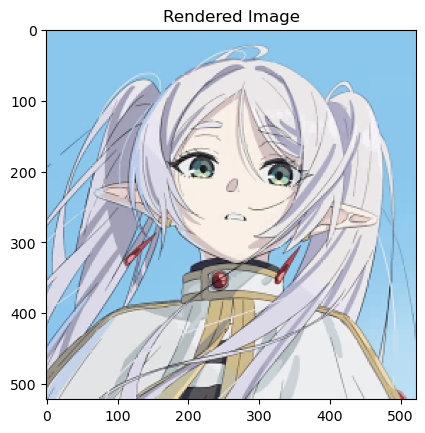

In [157]:
make_art(10000, path)